# BC4 Pipeline test

#### Goal: Track savings realised by the Energy Conservation Measures (ECMs) undertaken by the ESCO on a daily/weekly/monthly basis (M&V)

The Interamerican building was renovated in the time-frame from January 2018 to July 2018.

-> Create a model of the electricity consumption using the data before the renovation happened (pre-retrofit).

-> Get the "simulated" electricity consumption after the renovation of the building (post-retrofit).

-> Compare the twos to estimate the savings.

### 1. Read the harmonized time series in json format

In [153]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_bokeh
import json

from os import getcwd
from os.path import join
from rdflib import Graph, Namespace, URIRef, Literal

#pd.set_option('plotting.backend', 'pandas_bokeh')

#### - Define directories where the json and rdf files are located and print all the statements (triples with subject, predicate and object) in the rdf file

In [154]:
g = Graph()

dataset_dir = join(getcwd(), "datasets")
ts_filename = join(dataset_dir, "interamerican_ts.json")
rdf_filename = join(dataset_dir, "interamerican.ttl")

g.parse(rdf_filename, format="ttl")

for s, p, o in g:
    print("Subject: {}, Predicate: {}, Object: {}\n".format(s, p, o))

Subject: https://energis.cloud#METRIC-34766, Predicate: https://bigg-project.eu/ontology#measurementListStart, Object: 2022-03-28T23:00:00.000000000+00:00

Subject: https://energis.cloud#ASSET-58, Predicate: https://bigg-project.eu/ontology#addressProvince, Object: Barcelona

Subject: https://energis.cloud#Interamerican, Predicate: https://bigg-project.eu/ontology#buildingIDFromOrganization, Object: 58

Subject: https://energis.cloud#Interamerican, Predicate: https://bigg-project.eu/ontology#hasMeasurementLists, Object: https://energis.cloud#METRIC-34773

Subject: https://energis.cloud#METRIC-34773, Predicate: https://bigg-project.eu/ontology#measurementKey, Object: 34773

Subject: https://energis.cloud#METRIC-34778, Predicate: http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Object: https://bigg-project.eu/ontology#MeasurementList

Subject: https://energis.cloud#Interamerican, Predicate: http://www.w3.org/1999/02/22-rdf-syntax-ns#type, Object: https://bigg-project.eu/ontology#Building

#### - Convert the json loaded from file as a dictionary to a pandas dataframe and extract the name and aggregation functions of the time series from the rdf file

In [155]:
def get_aggregation(function: str) -> str:
        if function.lower() in ['avg', 'average']:
            return 'mean'
        else: 
            return function.lower()

def harmonized_dict_to_dataframe(data: dict, graph: Graph, ontology: str='https://bigg-project.eu/ontology#') -> (pd.DataFrame, dict):
    
    df_list = []
    agg_functions = {}
    namespace_ontology = Namespace(ontology)
    
    for name, time_series in data.items():
        measurement_list = graph.value(None, namespace_ontology['measurementKey'], Literal(name))
        if measurement_list is not None:
            measured_property = str(graph.value(measurement_list, namespace_ontology['measuredProperty'], None))
            agg_function = str(graph.value(measurement_list, namespace_ontology['aggregationFunction'], None))
            agg_functions[measured_property] = get_aggregation(agg_function)
        else:
            measured_property = name
        df_temp = pd.DataFrame.from_records(
                        time_series,
                        columns=["measurementStart", "value"]).rename(columns={"measurementStart": "timestamp", "value": measured_property})
        df_temp["timestamp"] = pd.to_datetime(
                    df_temp["timestamp"],
                    infer_datetime_format=True)
        df_temp.set_index('timestamp', inplace=True)
        df_list.append(df_temp)
        
    return pd.concat(df_list, axis=1), agg_functions

dataset_dir = join(getcwd(), "datasets")
filename = join(dataset_dir, "interamerican_ts.json")

with open(filename, 'r') as f:
    df, aggregations = harmonized_dict_to_dataframe(data=json.load(f), graph=g)
    
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2014-12-31 23:00:00+00:00,106.440000,NaN,NaN
2015-01-01 00:00:00+00:00,107.640000,4.76,0.0
2015-01-01 01:00:00+00:00,105.240000,4.37,0.0
2015-01-01 02:00:00+00:00,106.020000,4.35,0.0
2015-01-01 03:00:00+00:00,106.680000,4.31,0.0
...,...,...,...
2021-12-31 19:00:00+00:00,106.500002,10.62,0.0
2021-12-31 20:00:00+00:00,82.800001,10.13,0.0
2021-12-31 21:00:00+00:00,75.900001,9.72,0.0


In [156]:
# Check if the aggregation functions are correct 
aggregations

{'EnergyConsumptionGridElectricity': 'sum',
 'OutdoorTemperature': 'mean',
 'GlobalHorizontalIrradiation': 'sum'}

### 2. Describe and pairwise plots

#### - Get general statistics on the dataframe

In [157]:
df.describe()

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
count,55631.000000,61367.000000,61367.000000
mean,152.863544,18.205068,214.773459
std,231.258730,7.418170,295.082719
min,0.000000,-0.860000,0.000000
25%,87.720000,12.260000,0.000000
50%,107.375002,17.460000,10.206000
75%,193.320000,23.970000,395.912750
max,45682.300000,41.510000,1034.725000


#### - Print pairwise plot to check correlations
P.S.: In the plot we can clearly see that there are a few outliers messing up the feature scales.
We need to clean up the data.

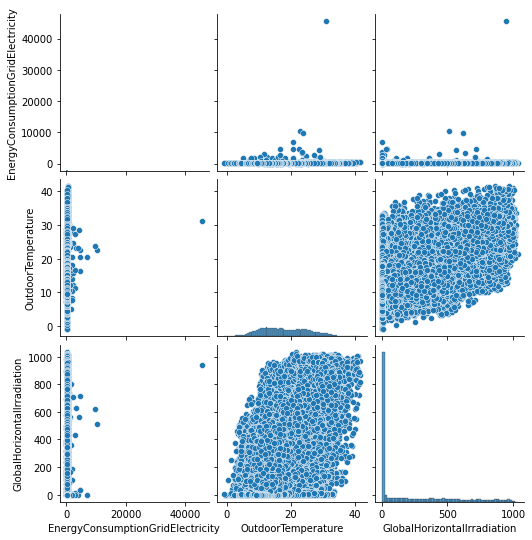

In [158]:
import seaborn as sns

sns.pairplot(data=df)

#### - Print correlation matrix

In [159]:
df.corr()

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
EnergyConsumptionGridElectricity,1.000000,0.195199,0.238085
OutdoorTemperature,0.195199,1.000000,0.510725
GlobalHorizontalIrradiation,0.238085,0.510725,1.000000


#### - Plot the data as they are

In [160]:
df.plot_bokeh.line(
    x=df.index, 
    y=["EnergyConsumptionGridElectricity", "OutdoorTemperature", "GlobalHorizontalIrradiation"],
    figsize=(1800, 900),
    ylim=(0, 700),
    zooming=True,
    panning=True,
)

Figure(id='6220', ...)

### 3. Clean up the data

#### - Check NaN per column

In [161]:
df.isna().sum(axis = 0)

EnergyConsumptionGridElectricity    5738
OutdoorTemperature                     2
GlobalHorizontalIrradiation            2
dtype: int64

#### - Check duplicated values

In [162]:
df[df.index.duplicated(False)]

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,


#### - Remove duplicates and keep last

In [163]:

df = df[~df.index.duplicated(keep='last')]
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2014-12-31 23:00:00+00:00,106.440000,NaN,NaN
2015-01-01 00:00:00+00:00,107.640000,4.76,0.0
2015-01-01 01:00:00+00:00,105.240000,4.37,0.0
2015-01-01 02:00:00+00:00,106.020000,4.35,0.0
2015-01-01 03:00:00+00:00,106.680000,4.31,0.0
...,...,...,...
2021-12-31 19:00:00+00:00,106.500002,10.62,0.0
2021-12-31 20:00:00+00:00,82.800001,10.13,0.0
2021-12-31 21:00:00+00:00,75.900001,9.72,0.0


#### - Check outliers with the zscore method, i.e. find all the datapoints that are farther than 4 std deviations from the mean. 

N.B. In our case, because of the seasonality factor, we group the data per month before calculating the zscore. This is like assuming that data distributions of the same month and different year can be considered more or less similar.
In this case we create another column in the dataframe just to plot the outliers vs series. 

In [164]:
import numpy as np
from scipy.stats import zscore

threshold = 4
outliers = df.groupby(by=[df.index.month])['EnergyConsumptionGridElectricity'].transform(lambda x: np.abs(zscore(x, ddof=1, nan_policy='omit')) > threshold)
df = df.assign(outliers= df.EnergyConsumptionGridElectricity.where(outliers))
df[~df.outliers.isna()]

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation,outliers
timestamp,,,,
2018-07-17 03:00:00+00:00,2249.316667,24.68,0.0000,2249.316667
2018-07-18 06:00:00+00:00,1622.300000,28.02,359.3259,1622.300000
2018-07-19 08:00:00+00:00,950.200000,30.26,733.2852,950.200000
2018-10-02 10:00:00+00:00,3288.834437,23.31,629.9535,3288.834437
2018-10-03 23:00:00+00:00,1034.250000,20.78,0.0000,1034.250000
2018-10-08 10:00:00+00:00,4732.750000,22.63,716.0392,4732.750000
2018-10-08 21:00:00+00:00,1532.000000,16.22,0.0000,1532.000000
2018-10-16 13:00:00+00:00,10380.000000,22.70,515.2156,10380.000000
2018-10-25 00:00:00+00:00,2191.333333,12.37,0.0000,2191.333333


#### - Plot the outliers and the series

In [165]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource
from bokeh.models import  HoverTool

tools_to_show = 'hover,box_zoom,pan,save,reset,wheel_zoom'
cds = ColumnDataSource(df)
p = figure(x_axis_type="datetime", height=900, width=1800, tools=tools_to_show, title= "Electricity consumption outliers")
p.line(
    x='timestamp',
    y="EnergyConsumptionGridElectricity",
    source=cds,
    legend_label="EnergyConsumptionGridElectricity",
    color="#104ca2"
)
p.circle(
    x='timestamp',
    y="outliers",
    source=cds,
    legend_label="outliers",
    color="#4b875f",
    size=8

)
p.legend.click_policy="hide"
hover = p.select(dict(type=HoverTool))
hover.formatters={'@timestamp': 'datetime'}
hover.tooltips = [("consumption", "@EnergyConsumptionGridElectricity{int}"), ("outlier", "@outliers{int}"), ("date", "@timestamp{%F}")]
hover.mode = 'mouse'
output_file("EnergyConsumptionGridElectricity_outliers.html")
show(p)

#### - Check yearly distributions

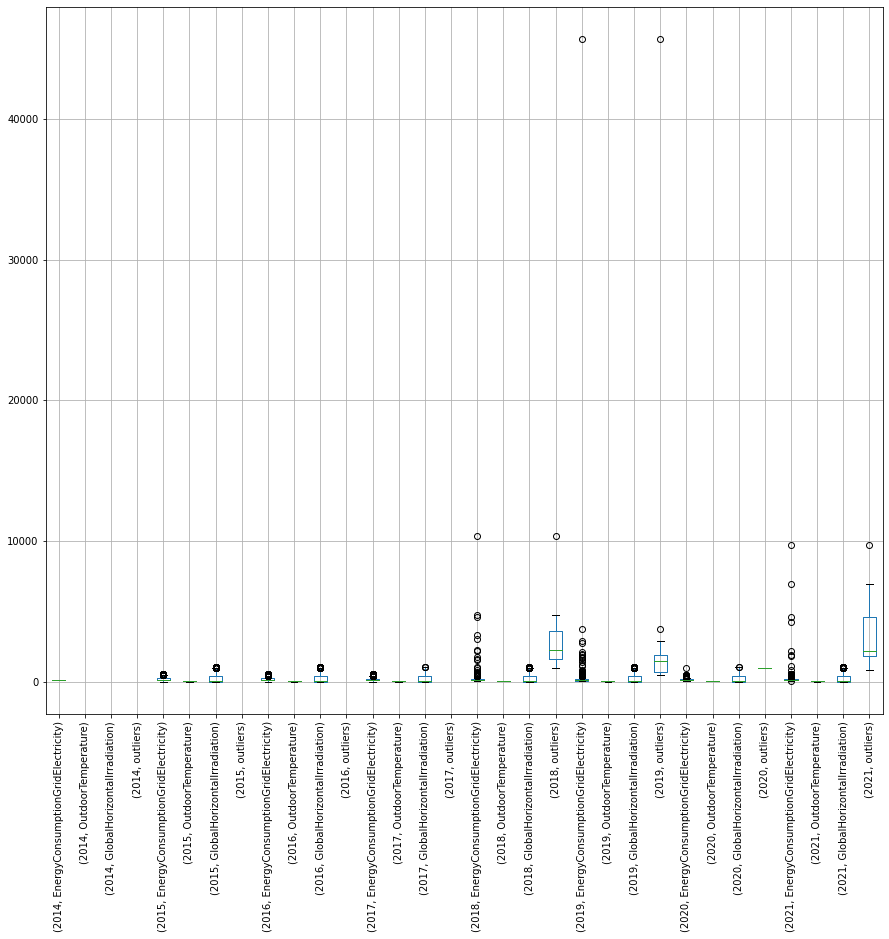

In [166]:
ax = df.groupby(by=df.index.year).boxplot(subplots=False, figsize=(15,13))
plt.xticks(rotation=90)
plt.show()

#### - Remove outliers and drop the column "outliers" used to create the plot

In [167]:
df = df[df.outliers.isna()]
df.drop(columns='outliers', inplace=True)
df

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
timestamp,,,
2014-12-31 23:00:00+00:00,106.440000,NaN,NaN
2015-01-01 00:00:00+00:00,107.640000,4.76,0.0
2015-01-01 01:00:00+00:00,105.240000,4.37,0.0
2015-01-01 02:00:00+00:00,106.020000,4.35,0.0
2015-01-01 03:00:00+00:00,106.680000,4.31,0.0
...,...,...,...
2021-12-31 19:00:00+00:00,106.500002,10.62,0.0
2021-12-31 20:00:00+00:00,82.800001,10.13,0.0
2021-12-31 21:00:00+00:00,75.900001,9.72,0.0


#### - Analyse frequencies of data grid with detect_time_step

Here we are lucky that the 3 series have the same frequency, even though we can see a lot of holes in the first series (electricity consumption)

In [168]:
from ai_toolbox.data_preparation import detect_time_step, align_time_grid
from pandas.tseries.frequencies import to_offset

list_freq = []
for column in df.columns.to_list():
    print("{}\n".format(detect_time_step(df[column])))
    list_freq.append(detect_time_step(df[column])[0])

('H',                    freq_count freqstr
0 days 01:00:00         55501       H
0 days 02:00:00            32      2H
0 days 04:00:00            10      4H
0 days 03:00:00            10      3H
0 days 06:00:00             3      6H
0 days 07:00:00             3      7H
0 days 17:00:00             3     17H
0 days 10:00:00             2     10H
0 days 08:00:00             2      8H
1 days 09:00:00             2     33H
2 days 20:00:00             2     68H
0 days 21:00:00             2     21H
0 days 16:00:00             1     16H
1 days 00:00:00             1       D
0 days 05:00:00             1      5H
0 days 13:00:00             1     13H
1 days 18:00:00             1     42H
0 days 19:00:00             1     19H
2 days 16:00:00             1     64H
13 days 00:00:00            1     13D
1 days 04:00:00             1     28H
0 days 09:00:00             1      9H
2 days 17:00:00             1     65H
0 days 14:00:00             1     14H
196 days 22:00:00           1   4726H
1 days

#### - Align time grid if necessary

If there are different frequencies in the data grid, get the max time step for the alignment and use the aggregation functions extracted from the rdf. In our case it is not necessary to align the frequecies because all the series have hourly frequency but they could be misaligned (Energis already does the alignment but we will use the function anyway for demo purposes).

In [169]:
if len(set(list_freq)) > 1:
    print("Data are not at the same frequency.")
else:
    print("All data are at the same frequency but could be misaligned.")

columns_resampled = []
max_freq = max(list_freq, key=to_offset)
df_new = df.resample(max_freq).agg(aggregations, skipna=False)

All data are at the same frequency but could be misaligned.


#### - Drop NaNs or fill with some method to develop in v2

In [170]:
df_new.dropna(inplace=True)

#### - Check again the correlations after we cleaned up the data
We can clearly see that the situation improved

In [171]:
df_new.corr()

,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation
EnergyConsumptionGridElectricity,1.000000,0.401963,0.475577
OutdoorTemperature,0.401963,1.000000,0.510735
GlobalHorizontalIrradiation,0.475577,0.510735,1.000000


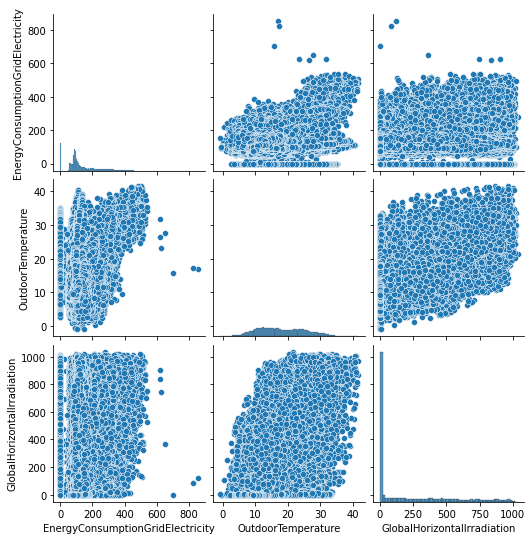

In [172]:
sns.pairplot(data=df_new)

### 4. Modeling

#### - Add calendar components to the dataframe

In [173]:
from ai_toolbox.data_transformation import add_calendar_components

components = ["month", "week", "weekday", "hour", "day"]

df_new = add_calendar_components(df_new, components)
df_new

/home/rick/Coding/Projects_github/biggpy/ai_toolbox/src/ai_toolbox/data_transformation.py:259: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  for component in calendar_components


,EnergyConsumptionGridElectricity,OutdoorTemperature,GlobalHorizontalIrradiation,month,week,weekday,hour,day
timestamp,,,,,,,,
2015-01-01 00:00:00+00:00,107.640000,4.76,0.0,1,1,3,0,1
2015-01-01 01:00:00+00:00,105.240000,4.37,0.0,1,1,3,1,1
2015-01-01 02:00:00+00:00,106.020000,4.35,0.0,1,1,3,2,1
2015-01-01 03:00:00+00:00,106.680000,4.31,0.0,1,1,3,3,1
2015-01-01 04:00:00+00:00,105.180000,4.20,0.0,1,1,3,4,1
...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,106.500002,10.62,0.0,12,52,4,19,31
2021-12-31 20:00:00+00:00,82.800001,10.13,0.0,12,52,4,20,31
2021-12-31 21:00:00+00:00,75.900001,9.72,0.0,12,52,4,21,31


#### - Transform the ordinal calendar component into sin/cosine components 

Here we use a transfomer to encode the calendar features into sin and cosine components, to make the model grasp the cyclic nature of these features. Also, the non-calendar features will be normalized using a Scaler.
This data trasformation allows some models to achieve way better performances.

In [174]:
from ai_toolbox.data_transformation import trigonometric_encode_calendar_components
from sklearn.preprocessing import StandardScaler

trigonometric_encoder = trigonometric_encode_calendar_components(
    data=df_new, 
    calendar_components=components,
    remainder=StandardScaler(),
    drop=True)

#### - Columns to be used as predictors 
We remove only the y feature, the one that we want to predict based on the predictor features. We also limit the time range of the predictors between the year 2015:2018 (2018 excluded).

In [175]:
to_remove = ['EnergyConsumptionGridElectricity']
predictors = [feature for feature in list(df_new.columns) if feature not in to_remove]
sorted(predictors)

['GlobalHorizontalIrradiation',
 'OutdoorTemperature',
 'day',
 'hour',
 'month',
 'week',
 'weekday']

In [176]:
X = df_new.loc['2015-01-01' : '2017-12-31', predictors]
X

,OutdoorTemperature,GlobalHorizontalIrradiation,month,week,weekday,hour,day
timestamp,,,,,,,
2015-01-01 00:00:00+00:00,4.76,0.0,1,1,3,0,1
2015-01-01 01:00:00+00:00,4.37,0.0,1,1,3,1,1
2015-01-01 02:00:00+00:00,4.35,0.0,1,1,3,2,1
2015-01-01 03:00:00+00:00,4.31,0.0,1,1,3,3,1
2015-01-01 04:00:00+00:00,4.20,0.0,1,1,3,4,1
...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,8.79,0.0,12,52,6,19,31
2017-12-31 20:00:00+00:00,8.93,0.0,12,52,6,20,31
2017-12-31 21:00:00+00:00,8.69,0.0,12,52,6,21,31


#### - Columns to be used as outcome variable
We also limit the time range of the outcome between the year 2015:2018 (2018 excluded).

In [177]:
y = df_new.loc['2015-01-01' : '2017-12-31', "EnergyConsumptionGridElectricity"]
y

timestamp
2015-01-01 00:00:00+00:00    107.64
2015-01-01 01:00:00+00:00    105.24
2015-01-01 02:00:00+00:00    106.02
2015-01-01 03:00:00+00:00    106.68
2015-01-01 04:00:00+00:00    105.18
                              ...  
2017-12-31 19:00:00+00:00     72.24
2017-12-31 20:00:00+00:00     74.34
2017-12-31 21:00:00+00:00     74.22
2017-12-31 22:00:00+00:00     72.18
2017-12-31 23:00:00+00:00      0.00
Name: EnergyConsumptionGridElectricity, Length: 26304, dtype: float64

#### - We use the function identify_best_model to find the best performing model based on the double cross validation results and retrain that model on the entire dataset. 

In [178]:
from ai_toolbox.data_modelling import identify_best_model, PolynomialRegression, BlockingTimeSeriesSplit
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt, ceil
from sklearn.pipeline import Pipeline

from time import time
import numpy as np

cv_splitter_outer = TimeSeriesSplit(n_splits=5)
cv_splitter_inner = TimeSeriesSplit(n_splits=3)

grid = {
    RandomForestRegressor():{
        'n_estimators': [10, 100],
        'max_features': np.linspace(ceil(sqrt(len(predictors))), len(predictors), 3, dtype=int)       
    },
    Pipeline([('trigon_encode', trigonometric_encoder), ('svr', SVR(cache_size=2000))]):{
        'svr__C': [0.1, 1, 10]
    },
    Pipeline([('trigon_encode', trigonometric_encoder), ('poly', PolynomialRegression())]):{
        'poly__degree': list(range(1, 4)) 
    }
}  
start_time = time()
results = identify_best_model(
    X_data=X,
    y_data=y,
    model_families_parameter_grid=grid,
    cv_inner=cv_splitter_inner,
    cv_outer=cv_splitter_outer,
    scoring=['r2', 'mean_bias_error', 'neg_root_mean_squared_error', 'normalized_mean_bias_error', 'cv_rmse'],
    compare_with='r2'
)

print("Best model: {}\n".format(results[0]))
print("Best parameters: {}\n".format(results[1]))
print("Mean score: {}\n".format(results[2]))
print("Std score: {}\n".format(results[3]))
print("Evaluation results: {}\n".format(results[5]))

print("Time to identify best model: {} seconds.".format(time()-start_time))

Best model: RandomForestRegressor(max_features=3)

Best parameters: {'max_features': 3, 'n_estimators': 100}

Mean score: 0.887001266712754

Std score: 0.028116979143838584

Evaluation results: {'RandomForestRegressor()': {'test_r2': {'mean': 0.887001266712754, 'std': 0.028116979143838584}, 'test_mean_bias_error': {'mean': 2.3029239142335762, 'std': 7.557721752168752}, 'test_neg_root_mean_squared_error': {'mean': -34.73631124841754, 'std': 3.8254352800448124}, 'test_normalized_mean_bias_error': {'mean': 1.5202809043559147, 'std': 4.14951719225127}, 'test_cv_rmse': {'mean': -20.516016476626703, 'std': 1.8010090447988374}}, 'SVR(cache_size=2000)': {'test_r2': {'mean': 0.8235583317082664, 'std': 0.08733066746382558}, 'test_mean_bias_error': {'mean': -3.2585209391603107, 'std': 7.0604080453854525}, 'test_neg_root_mean_squared_error': {'mean': -43.55270149156229, 'std': 13.6594774467206}, 'test_normalized_mean_bias_error': {'mean': -1.7572278371295582, 'std': 3.793666121527117}, 'test_cv_rm

#### - Check the scores of the different model families

In [179]:
pd.DataFrame.from_dict(results[5])

,RandomForestRegressor(),SVR(cache_size=2000),PolynomialRegression()
test_r2,"{'mean': 0.887001266712754, 'std': 0.028116979...","{'mean': 0.8235583317082664, 'std': 0.08733066...","{'mean': 0.6092967808860343, 'std': 0.10831196..."
test_mean_bias_error,"{'mean': 2.3029239142335762, 'std': 7.55772175...","{'mean': -3.2585209391603107, 'std': 7.0604080...","{'mean': 11.432327115250482, 'std': 10.1314690..."
test_neg_root_mean_squared_error,"{'mean': -34.73631124841754, 'std': 3.82543528...","{'mean': -43.55270149156229, 'std': 13.6594774...","{'mean': -64.66259876910496, 'std': 12.2935693..."
test_normalized_mean_bias_error,"{'mean': 1.5202809043559147, 'std': 4.14951719...","{'mean': -1.7572278371295582, 'std': 3.7936661...","{'mean': 6.394264899735338, 'std': 5.257952473..."
test_cv_rmse,"{'mean': -20.516016476626703, 'std': 1.8010090...","{'mean': -25.35453707255612, 'std': 6.05844991...","{'mean': -38.02572251781384, 'std': 5.45014791..."


#### - Check the cross validation results of the best model retrained on the entire dataset

In [180]:
pd.DataFrame.from_dict(results[4])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.231210,0.096266,0.012628,0.000315,3,10,"{'max_features': 3, 'n_estimators': 10}",0.814517,0.911522,0.901487,0.875842,0.043556,6
1,2.939275,1.479433,0.122940,0.020917,3,100,"{'max_features': 3, 'n_estimators': 100}",0.835536,0.917146,0.908622,0.887102,0.036628,1
2,0.347070,0.142622,0.012525,0.000759,5,10,"{'max_features': 5, 'n_estimators': 10}",0.819899,0.910086,0.900943,0.876976,0.040532,5
3,4.145542,1.755166,0.115600,0.006531,5,100,"{'max_features': 5, 'n_estimators': 100}",0.833071,0.915004,0.907219,0.885098,0.036926,2
4,0.491671,0.250831,0.014722,0.004027,7,10,"{'max_features': 7, 'n_estimators': 10}",0.832611,0.905219,0.894453,0.877427,0.031994,4
5,5.114895,1.696103,0.107266,0.008494,7,100,"{'max_features': 7, 'n_estimators': 100}",0.832156,0.913526,0.901106,0.882263,0.035792,3


In [181]:
best_model = results[0]

#### - Check the feature importances of the RandomForest model

In [182]:
for k, v in zip(predictors, best_model.feature_importances_):
    print(k, v)

OutdoorTemperature 0.20988868313662976
GlobalHorizontalIrradiation 0.287852716449696
month 0.01922380022867558
week 0.037437163942325394
weekday 0.3277214970470422
hour 0.09870287976135134
day 0.0191732594342798


#### - Add the y_predicted to the dataframe for visualization purposes

In [183]:
df_new["y_pred"] = best_model.predict(df_new[predictors])

#### - Plot Actual Consumption and predictions
We are predicting how the consumptions would be without retrofit and thus estimating the savings in the post-retrofit period (after July 2018).

In [185]:
figure = df_new.plot_bokeh.line(
    title = "Prediction model 2015-2018 vs Actual Consumptions",
    x=df_new.index, 
    y=["EnergyConsumptionGridElectricity", "y_pred"],
    figsize=(1800, 900),
    ylim=(0, 1000),
    zooming=True,
    panning=True,
)
pandas_bokeh.output_file("predictions_EnergyConsumptionGridElectricity.html")

#### - Export the data in the Energis format
(The code below is just to export the data to an Energis-formatter csv)

In [186]:
df_export = df_new[["y_pred"]]
df_export = df_export.rename(columns={"y_pred": "EnergyConsumptionGridElectricity.forecasted"})
df_export.index.name = "Date"
df_export.index = df_export.index.strftime('%d/%m/%Y %H:%M')
df_export

,EnergyConsumptionGridElectricity.forecasted
Date,
01/01/2015 00:00,105.8022
01/01/2015 01:00,104.8656
01/01/2015 02:00,105.1170
01/01/2015 03:00,105.6564
01/01/2015 04:00,104.5890
...,...
31/12/2021 19:00,138.0474
31/12/2021 20:00,129.7476
31/12/2021 21:00,106.1550


In [187]:
df_export.to_csv("EnergyConsumptionGridElectricity_forecasted.csv", sep=';')